# Test du solveur par transport optimal

Le but de ce notebook est d'analyser les résultats fournis par notre solveur par transport optimal, défini dans un précédent notebook.

## Code du solveur

Voici le code précédemment généré pour le solveur.

In [1]:
import ot
import scipy.optimize, scipy.signal
import numpy as np
import matplotlib.pyplot as plt

def frequential_cost_matrix(F):
    """
    Generates a frequential cost matrix, i.e. the frequency moving cost.
    ---
    Inputs:
        - F : 1-D float array. The range of frequencies to be considered.
    ---
    Outputs
        - C : 2-D float array. The wanted cost matrix.
    """
    M = F.shape[0]
    C = np.zeros((M,M))
    for i in range(M):
        for j in range(M):
            C[i,j] = (F[i]-F[j])**2
    return C

def simplex_OT_canonical_matrices(v, W, C):
    """
    Generates the canonical matrices for the simplex algorithm.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    """
    M = v.shape[0]
    K = W.shape[1]
    # Coefficients for minimization
    c = np.zeros((M**2+ K,))
    #Constraints matrix and vertice
    A = np.zeros((2*M,M**2+ K))
    b = np.zeros((2*M,))
    
    # c is unfolding C and letting zeros after
    c[:M**2] =  [C[i//M, i%M] for i in range(M**2)]
    
    # Writing first constraints set
    for i in range(M):
        for j in range(M):
            A[i, i*M+j] = 1
        b[i] = v[i] 
    
    # Writing second constraints set
    for j in range(M):
        for i in range(M):
            A[M + j, i*M+j] = 1
        for k in range(K):
            A[M + j, M**2 +k] = -W[j,k]
    
    # Returning matrices
    return c, A, b

def simplex_algorithm(c, A, b):
    """
    Returns the optimal solution found by the simplex algorithm.
    ---
    Inputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    ---
    Outputs:
        - x : 1-D float array. The simplex's optimal solution, 
                    i.e. the vector that minimizes <c.x>, 
                    so that Ax = b.            
    """
    #result = scipy.optimize.linprog(c, method="simplex", options={'A':A, 'b':b})
    result = scipy.optimize.linprog(c, A_eq=A, b_eq=b,bounds=(0, None))
    if not result.success:
        print("Failure: ", result.message)
    print("Simplex iterations:", result.nit)
    return result.x

def compute_NMF(v,W,C):
    """
    Computes a Non-negative Matrix Factorization of v based on W, optimizing with respects to C.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - h : 1-D float array. An optimal vector so that v ~ Wh, with respects to C.
    """
    c, A, b = simplex_OT_canonical_matrices(v, W, C)
    th = simplex_algorithm(c, A, b)
    K = W.shape[1]
    h = th[-K:]
    return h

def slice_spectrogram(f, t, S, fmin=0, fmax=50000):
    """
    Slices the frequences of a spectrogram.
    -- 
    Inputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
    ---
    Outputs:
        - f : 1-D float array. The sliced spectrogram's frequency values.
        - t : 1-D float array. The sliced spectrogram's time values.
        - S : 2-D float array. The slicespectrogram.
    """
    freq_slice = np.where((f >= fmin) & (f <= fmax) )

    f = f[freq_slice]
    S = S[freq_slice,:][0]

    return f, t, S

def get_spectrogram(s, fs, fmin=0, fmax=50000):
    """
    Returns the spectrogram of a signal s.
    ---
    Inputs:
        - s : 1-D float array. The considered signal.
        - fs : float. The sampling frequency of the signal.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
    ---
    Outputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    """
    f, t, S = scipy.signal.spectrogram(s, fs=fs)
    f, t, S = slice_spectrogram(f, t, S, fmin, fmax)
    return f, t, S

def normalize_trame(v):
    """
    Normalizes a spectrogram trame v.
    ---
    Inputs:
        - v : 1-D float array. The spectrogram trame
    ---
    Outputs:
        - normalized_v: 1-D float array. The normalized spectrogram trame
    """
    normalized_v = v/np.sum(v)
    return normalized_v

## Génération des signaux de base

On définit ici plusieurs signaux de base pour pouvoir les manipuler.

In [2]:
# Sample frequency
fs = 10e4
# Values amount
N = 5000
# Time
T = np.arange(N) / fs

# Base frequencies, conveniently aligned on scipy.signal base values.
base_freqs = [
               781.25,
               1171.875,
               3125,
               4296.875
             ]

elementary_signals = [np.sin(2*np.pi*f*T) for f in base_freqs]
# Base signals
base_signals = elementary_signals.copy()

On définit également un bruit blanc, afin de pouvoir bruiter nos signaux.

In [3]:
import random
# White noise, i.e a random signal
white_noise = [random.random()/10 for t in T]

## Génération du dictionnaire

Nous définissons désormais notre dictionnaire à l'aide de nos signaux de base.

(13, 4) = 13 4
-----


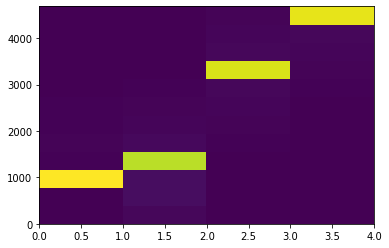

In [4]:
# Cutting frequencies
FMIN = 0
FMAX = 5000

# Computing the spectrograms
spectrograms = [get_spectrogram(s, fs,  FMIN, FMAX)[0] for s in base_signals]
f, t, _ = get_spectrogram(base_signals[0], fs,  FMIN, FMAX)

# Dimensions :
# M: number of examples
M = len(base_signals)
# N: number of considered frequencies
N = spectrograms[0].shape[0]

# Dictionnary declaration (assumes that base signal are frequency constant through time)
W = np.array([normalize_trame(get_spectrogram(s, fs,  FMIN, FMAX)[-1][:,N//2]) for s in base_signals]).transpose()

print(W.shape, "=", N,M)
print("-----")
plt.pcolormesh(range(M+1), f, W)
plt.show()

## Génération de la matrice de coût

Nous générons enfin la matrice de coût associée.

In [5]:
C = frequential_cost_matrix(f)

## Génération d'un signal-jouet

Nous définissons ici les signaux de test.

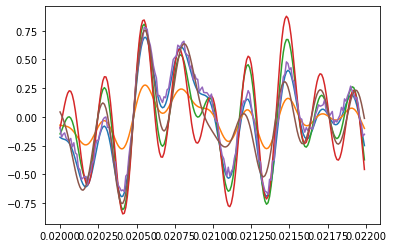

In [6]:
# First, simple signal. Same amplitude, with all coefficients equals.
coeffs1 = [1/len(base_signals) for s in base_signals]
s1 = np.dot(coeffs1, base_signals)

# Augmented amplitude
coeffs2 = [0.1 for s in base_signals]
s2 = np.dot(coeffs2, base_signals)

# Custom coefficients - All signals presents
coeffs3 = [0.1,0.2,0.3,0.4]
s3 = np.dot(coeffs3, base_signals)

# A signal is not component
coeffs4 = [0,0.25,0.25,0.5]
s4 = np.dot(coeffs4, base_signals)

# Noisy signal
coeffs5 = coeffs1
s5 = s1 + white_noise

# Let us trick a bit, by adding a signal absent from the dictionnary.
coeffs6 = [0.2,0.2,0.2,0.2]
f6 = 3515.625
s6 = np.dot(coeffs6, base_signals) + np.array([0.2*np.sin(2*np.pi*f6*t) for t in T])

start_index = 2000
size = 200
plt.plot(T[start_index:start_index+size],s1[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s2[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s3[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s4[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s5[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s6[start_index:start_index+size])
plt.show()

Nous calculons ensuite les spectrogrammes.

In [7]:
f1, t1, S1 = get_spectrogram(s1, fs, fmin=FMIN, fmax=FMAX)
f2, t2, S2 = get_spectrogram(s2, fs, fmin=FMIN, fmax=FMAX)
f3, t3, S3 = get_spectrogram(s3, fs, fmin=FMIN, fmax=FMAX)
f4, t4, S4 = get_spectrogram(s4, fs, fmin=FMIN, fmax=FMAX)
f5, t5, S5 = get_spectrogram(s5, fs, fmin=FMIN, fmax=FMAX)
f6, t6, S6 = get_spectrogram(s6, fs, fmin=FMIN, fmax=FMAX)

Et enfin nous calculons une trame de ce spectrogramme.

Fréquences : [781.25, 1171.875, 3125, 4296.875]
Fréquences de v1


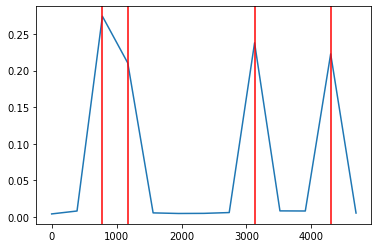

Fréquences de v2 (identiques à v1)


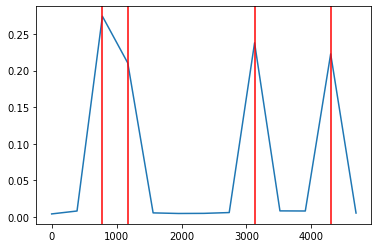

Fréquences de v3 (déséquilibré)


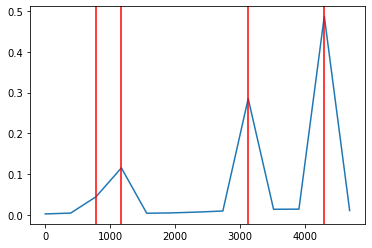

Fréquences de v4 (pas de f1)


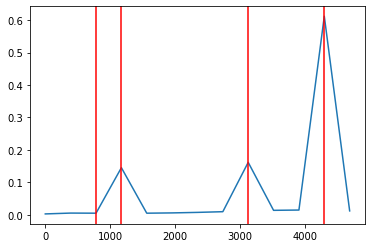

Fréquences de v5 (bruit)


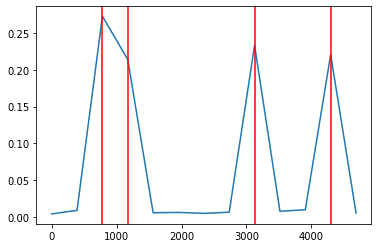

Fréquences de v6 (signal étranger)


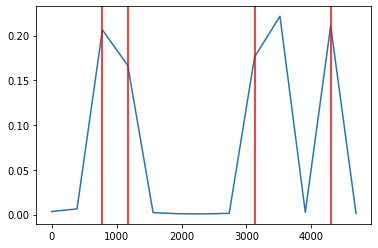

In [8]:
v1 = normalize_trame(S1[:,N//2])
v2 = normalize_trame(S2[:,N//2])
v3 = normalize_trame(S3[:,N//2])
v4 = normalize_trame(S4[:,N//2])
v5 = normalize_trame(S5[:,N//2])
v6 = normalize_trame(S6[:,N//2])

print("Fréquences :", base_freqs)

print("Fréquences de v1")
plt.plot(f,v1)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()
print("Fréquences de v2 (identiques à v1)")
plt.plot(f,v2)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()
print("Fréquences de v3 (déséquilibré)")
plt.plot(f,v3)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()
print("Fréquences de v4 (pas de f1)")
plt.plot(f,v4)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()
print("Fréquences de v5 (bruit)")
plt.plot(f,v5)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()
print("Fréquences de v6 (signal étranger)")
plt.plot(f,v6)
for freq in base_freqs:
    plt.axvline(freq, color = "red")
plt.show()

## Tests

Nous passons désormais aux tests

In [9]:
print("--- Cas de base")
print("h1 = ", compute_NMF(v1,W,C))
print("Note : devrait être proche de", coeffs1/np.sum(coeffs1))
print()
print("--- Amplitude modifiée")
print("h2 = ", compute_NMF(v2,W,C))
print("Note : devrait être proche de", coeffs2/np.sum(coeffs2))
print()
print("--- Coefficients variables")
print("h3 = ", compute_NMF(v3,W,C))
print("Note : devrait être proche de", coeffs3/np.sum(coeffs3))
print()
print("--- Un signal absent")
print("h4 = ", compute_NMF(v4,W,C))
print("Note : devrait être proche de", coeffs4/np.sum(coeffs4))
print()
print("--- Signal bruité")
print("h5 = ", compute_NMF(v5,W,C))
print("Note : devrait être proche de", coeffs5/np.sum(coeffs5))
print()
print("--- Signal avec une composante inconnue")
print("h6 = ", compute_NMF(v5,W,C))
print("Note : devrait être proche de", coeffs5/np.sum(coeffs5))

--- Cas de base
Simplex iterations: 15
h1 =  [0.27498722 0.23312992 0.25562231 0.23626054]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Amplitude modifiée
Simplex iterations: 15
h2 =  [0.27498722 0.23312992 0.25562231 0.23626054]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Coefficients variables
Simplex iterations: 15
h3 =  [0.04080846 0.13057401 0.3100139  0.51860363]
Note : devrait être proche de [0.1 0.2 0.3 0.4]

--- Un signal absent
Simplex iterations: 14
h4 =  [3.31810606e-16 1.68157106e-01 1.78473346e-01 6.53369549e-01]
Note : devrait être proche de [0.   0.25 0.25 0.5 ]

--- Signal bruité
Simplex iterations: 15
h5 =  [0.2738875  0.23917564 0.2507542  0.23618266]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Signal avec une composante inconnue
Simplex iterations: 15
h6 =  [0.2738875  0.23917564 0.2507542  0.23618266]
Note : devrait être proche de [0.25 0.25 0.25 0.25]


## Altération du dictionnaire

Complexifions désormais notre dictionnaire en lui donnant une composante composée de deux signaux élémentaires

##############################
(13, 4) = 13 4
-----


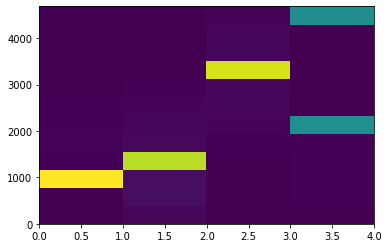

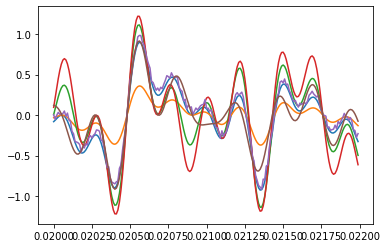

##############################


In [10]:
base_signals = elementary_signals.copy()
base_signals[3] += np.sin(2*np.pi*1953.125*T)

# Computing the spectrograms
spectrograms = [get_spectrogram(s, fs,  FMIN, FMAX)[0] for s in base_signals]

# Dictionnary declaration (assumes that base signal are frequency constant through time)
W = np.array([normalize_trame(get_spectrogram(s, fs,  FMIN, FMAX)[-1][:,N//2]) for s in base_signals]).transpose()

####################################################################################################################
print("#"*30)

print(W.shape, "=", N,M)
print("-----")
plt.pcolormesh(range(M+1), f, W)
plt.show()

# First, simple signal. Same amplitude, with all coefficients equals.
coeffs1 = [1/len(base_signals) for s in base_signals]
s1 = np.dot(coeffs1, base_signals)

# Augmented amplitude
coeffs2 = [0.1 for s in base_signals]
s2 = np.dot(coeffs2, base_signals)

# Custom coefficients - All signals presents
coeffs3 = [0.1,0.2,0.3,0.4]
s3 = np.dot(coeffs3, base_signals)

# A signal is not component
coeffs4 = [0,0.25,0.25,0.5]
s4 = np.dot(coeffs4, base_signals)

# Noisy signal
coeffs5 = coeffs1
s5 = s1 + white_noise

# Let us trick a bit, by adding a signal absent from the dictionnary.
coeffs6 = [0.2,0.2,0.2,0.2]
f6 = 3515.625
s6 = np.dot(coeffs6, base_signals) + np.array([0.2*np.sin(2*np.pi*f6*t) for t in T])

start_index = 2000
size = 200
plt.plot(T[start_index:start_index+size],s1[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s2[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s3[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s4[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s5[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s6[start_index:start_index+size])
plt.show()

####################################################################################################################
print("#"*30)

f1, t1, S1 = get_spectrogram(s1, fs, fmin=FMIN, fmax=FMAX)
f2, t2, S2 = get_spectrogram(s2, fs, fmin=FMIN, fmax=FMAX)
f3, t3, S3 = get_spectrogram(s3, fs, fmin=FMIN, fmax=FMAX)
f4, t4, S4 = get_spectrogram(s4, fs, fmin=FMIN, fmax=FMAX)
f5, t5, S5 = get_spectrogram(s5, fs, fmin=FMIN, fmax=FMAX)
f6, t6, S6 = get_spectrogram(s6, fs, fmin=FMIN, fmax=FMAX)

####################################################################################################################
v1 = normalize_trame(S1[:,N//2])
v2 = normalize_trame(S2[:,N//2])
v3 = normalize_trame(S3[:,N//2])
v4 = normalize_trame(S4[:,N//2])
v5 = normalize_trame(S5[:,N//2])
v6 = normalize_trame(S6[:,N//2])

Observons les résultats de cette résolution :

In [11]:
print("--- Cas de base")
print("h1 = ", compute_NMF(v1,W,C))
print("Note : devrait être proche de =", coeffs1/np.sum(coeffs1))
print()
print("--- Amplitude modifiée")
print("h2 = ", compute_NMF(v2,W,C))
print("Note : devrait être proche de =", coeffs2/np.sum(coeffs2))
print()
print("--- Coefficients variables")
print("h3 = ", compute_NMF(v3,W,C))
print("Note : devrait être proche de =", coeffs3/np.sum(coeffs3))
print()
print("--- Un signal absent")
print("h4 = ", compute_NMF(v4,W,C))
print("Note : devrait être proche de =", coeffs4/np.sum(coeffs4))
print()
print("--- Signal bruité")
print("h5 = ", compute_NMF(v5,W,C))
print("Note : devrait être proche de =", coeffs5/np.sum(coeffs5))
print()
print("--- Signal avec une composante inconnue")
print("h6 = ", compute_NMF(v5,W,C))
print("Note : devrait être proche de =", coeffs5/np.sum(coeffs5))

--- Cas de base
Simplex iterations: 15
h1 =  [0.18717791 0.24506986 0.19078798 0.37696425]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Amplitude modifiée
Simplex iterations: 15
h2 =  [0.18717791 0.24506986 0.19078798 0.37696425]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Coefficients variables
Simplex iterations: 16
h3 =  [0.00535937 0.14289638 0.18439806 0.66734618]
Note : devrait être proche de = [0.1 0.2 0.3 0.4]

--- Un signal absent
Simplex iterations: 16
h4 =  [2.90727407e-14 1.46942836e-01 9.21063728e-02 7.60950791e-01]
Note : devrait être proche de = [0.   0.25 0.25 0.5 ]

--- Signal bruité
Simplex iterations: 14
h5 =  [0.18478099 0.25553818 0.18607941 0.37360141]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Signal avec une composante inconnue
Simplex iterations: 14
h6 =  [0.18478099 0.25553818 0.18607941 0.37360141]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]


On note que la précision faiblit fortement. **Cependant**, il est à noter que la tendance globale semble conservée. Il est donc possible que cela soit fortement amélioré par le spectrogramme.